In [14]:
# load các thư viện cần thiết
import math
from vnstock import *
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder,StandardScaler,PowerTransformer, MinMaxScaler, RobustScaler

Observations:  1630


<Axes: xlabel='Time'>

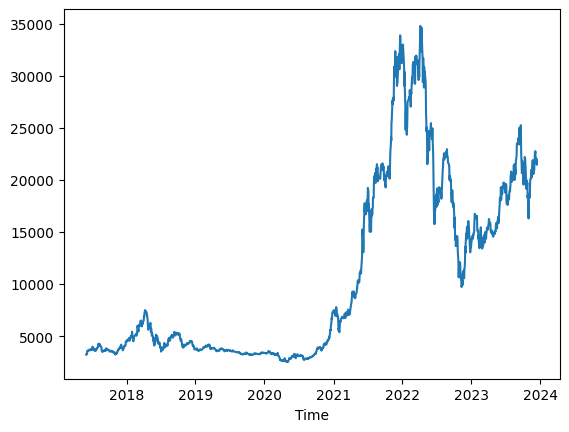

In [15]:
#2. Fetch data and visualize
# VND
VND = stock_historical_data(symbol = "VND", start_date="2017-06-01", end_date="2023-12-15", resolution="1D", type = "stock", beautify=True, decor=True, source = "DNSE")
from matplotlib import pyplot
print("Observations: ",len(VND['Close']))
train_dates = VND.index
df = VND["Close"]
df.plot()

In [16]:
# Split data into training (80%) and test (20%)
np.random.seed(42)
train, test = train_test_split(df, test_size=0.2, shuffle=False)

In [17]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(df.values.reshape(-1, 1))

train_data =  scaler.fit_transform(train.values.reshape(-1, 1))
test_data = scaler.fit_transform(test.values.reshape(-1, 1))

In [18]:
# Chia dữ liệu thành các mẫu chuỗi thời gian
def create_time_series(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

In [19]:
time_steps = 30  # Số ngày quan sát trước để dự đoán ngày tiếp theo
X_train, y_train = create_time_series(train_data, time_steps)
X_test, y_test = create_time_series(test_data, time_steps)

In [20]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [21]:
# Tạo model lstm cho việc training
# BILSTM
model = Sequential()
model.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(32, activation='relu', return_sequences=False)))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1]))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 30, 128)           33792     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 75073 (293.25 KB)
Trainable params: 75073 (293.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
# fit the model
history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_split=0.1, verbose=1)

Epoch 1/50
115/115 [==============================] - 5s 18ms/step - loss: 0.0111 - val_loss: 0.0113
Epoch 2/50
115/115 [==============================] - 2s 15ms/step - loss: 0.0029 - val_loss: 0.0129
Epoch 3/50
115/115 [==============================] - 2s 14ms/step - loss: 0.0020 - val_loss: 0.0082
Epoch 4/50
115/115 [==============================] - 2s 14ms/step - loss: 0.0020 - val_loss: 0.0064
Epoch 5/50
115/115 [==============================] - 2s 13ms/step - loss: 0.0022 - val_loss: 0.0061
Epoch 6/50
115/115 [==============================] - 2s 16ms/step - loss: 0.0015 - val_loss: 0.0056
Epoch 7/50
115/115 [==============================] - 2s 13ms/step - loss: 0.0017 - val_loss: 0.0050
Epoch 8/50
115/115 [==============================] - 2s 16ms/step - loss: 0.0013 - val_loss: 0.0055
Epoch 9/50
115/115 [==============================] - 2s 16ms/step - loss: 0.0016 - val_loss: 0.0052
Epoch 10/50
115/115 [==============================] - 1s 12ms/step - loss: 0.0014 - val_lo

In [23]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error

# Dự đoán giá trong quá trình testing
y_test_predicted = model.predict(X_test)

# Đưa các dự đoán về lại tỷ lệ ban đầu
y_test_predicted1 = scaler.inverse_transform(y_test_predicted)

y_test1 = scaler.inverse_transform(y_test)


# Tính MAE cho testing
mae_test = mean_absolute_error(y_test1, y_test_predicted1)

# Tính MAPE cho testing
mape_test = mean_absolute_percentage_error(y_test1, y_test_predicted1) * 100

# Tính RMSE cho testing
rmse_test = mean_squared_error(y_test1, y_test_predicted1, squared=False)

# Tính MSLE cho testing
msle_test = mean_squared_log_error(y_test1, y_test_predicted1, squared=False)

10/10 [==============================] - 0s 5ms/step


In [24]:
print('---------TEST----------')
print("MAPE:", round(mape_test,3))
print("MAE:", round(mae_test,3))
print("RMSE:", round(rmse_test,3))
print("MSLE:", round(msle_test,3))
print('-------------------')

---------TEST----------
MAPE: 6.933
MAE: 1032.117
RMSE: 1368.804
MSLE: 0.094
-------------------


In [25]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

y_test_pred = scaler.inverse_transform(y_test_predicted)

n_past = 1
n_days_for_prediction= 60

#create an array of next 60 dates starting from last date in dataset
predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction).tolist()

# print(predict_period_dates)

#Make prediction
prediction = model.predict(X_test[-n_days_for_prediction:])

prediction_copies = np.repeat(prediction, df.shape[0], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]

2/2 [==============================] - 0s 18ms/step


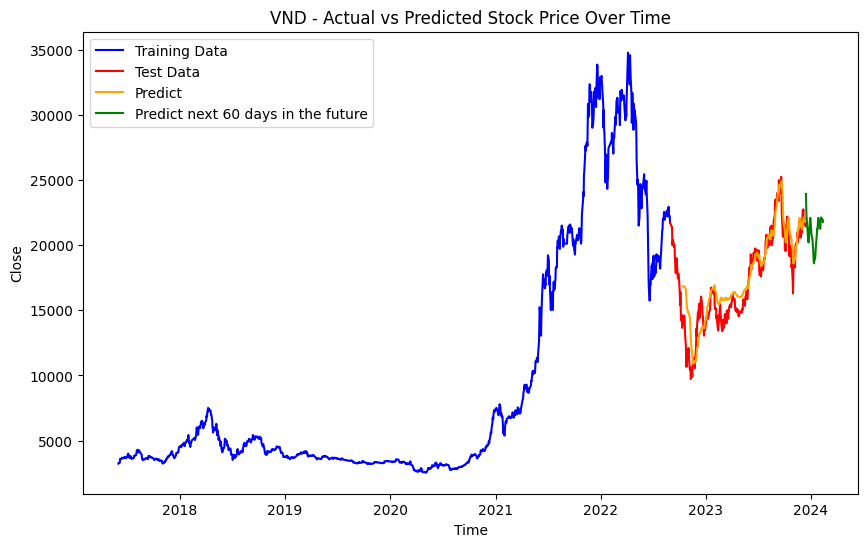

In [26]:
# Tạo biểu đồ train, test và dự đoán 60 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train.index, train.values, linestyle='-', color='b', label='Training Data')
plt.plot(test.index,test.values, linestyle='-',  color='r', label='Test Data')
predict_date = test.index;
plt.plot(predict_date[30:],  y_test_pred, label='Predict', linestyle='-',  color='orange')
# # Plot predicted values
plt.plot( predict_period_dates, y_pred_future, label='Predict next 60 days in the future', linestyle='-',  color='g')

plt.title('VND - Actual vs Predicted Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.show()